In [76]:
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa
import random
import shutil
from matplotlib.backends.backend_agg import FigureCanvasAgg
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Model
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K

In [4]:
dataset_dir = 'genres_original/'
genre_labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

Finished: blues
Finished: classical
Finished: country
Finished: disco
Finished: hiphop
Finished: jazz
Finished: metal
Finished: pop
Finished: reggae
Finished: rock


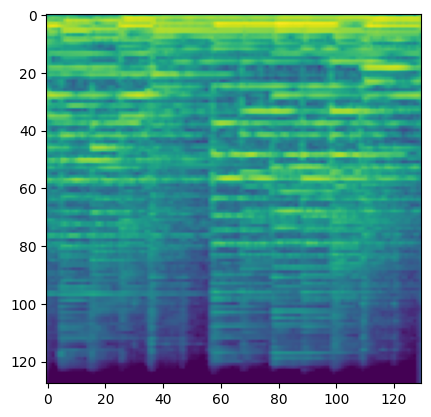

In [5]:
for genre_index, genre_label in enumerate(genre_labels):
    i = 0
    genre_dir = os.path.join(dataset_dir, genre_label)

    for file in os.listdir(genre_dir):
        file_path = os.path.join(genre_dir, file)
        i = i + 1
        
        y, sr = librosa.load(file_path, duration=3)
        mels = librosa.feature.melspectrogram(y=y, sr=sr)
        
        fig = plt.Figure()
        canvas = FigureCanvasAgg(fig)
        p = plt.imshow(librosa.power_to_db(mels, ref=np.max))
        
        path = f'./spectrograms/train/{genre_label}/'
        if not os.path.exists(path):
            os.makedirs(path)
        
        plt.savefig(f'./spectrograms/train/{genre_label}/{genre_label}{i}.png')
        
    print('Finished:', genre_label)

In [3]:
directory = './spectrograms/train/'

for genre in genre_labels:
    filenames = os.listdir(os.path.join(directory, f"{genre}"))
    
    random.shuffle(filenames)
    test_files = filenames[0:20]
    
    for file in test_files:
        path = f"{directory[:-6]}test/{genre}"
        if not os.path.exists(path):
            os.makedirs(path)
        
        shutil.move(f"{directory}{genre}/{file}", path)

NameError: name 'genre_labels' is not defined

In [5]:
train_directory = directory
train_data_generator = ImageDataGenerator(rescale=1./255)

validation_directory = f"{directory[:-6]}test/"
validation_data_generator = ImageDataGenerator(rescale=1./255)

train_generator = train_data_generator.flow_from_directory(train_directory, target_size=(
    288, 432), color_mode="rgba", class_mode='categorical', batch_size=128)

validation_generator = validation_data_generator.flow_from_directory(validation_directory, target_size=(
    288, 432), color_mode='rgba', class_mode='categorical', batch_size=128)

Found 800 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [6]:
def cnn(input_shape=(288, 432, 4), classes=10):
    def step(dim, X):
        X = Conv2D(dim, kernel_size=(3, 3), strides=(1, 1))(X)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)
        return MaxPooling2D((2, 2))(X)
    
    X_input = Input(input_shape)
    X = X_input
    layer_dims = [8, 16, 32, 64, 128, 256]
    for dim in layer_dims:
        X = step(dim, X)

    X = Flatten()(X)
    X = Dropout(rate=0.3)(X)
    X = Dense(classes, activation='softmax',
              name=f'fc{classes}',  kernel_initializer=glorot_uniform(seed=9))(X)
    
    model = Model(inputs=X_input, outputs=X, name='cnn')
    return model

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [7]:
model = cnn(input_shape=(288, 432, 4), classes=10)
opt = Adam(learning_rate=0.00005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', f1_score])

In [ ]:
history = model.fit(train_generator, epochs=100, validation_data=validation_generator)

In [10]:
model.save('genre_model.h5', save_format='h5')

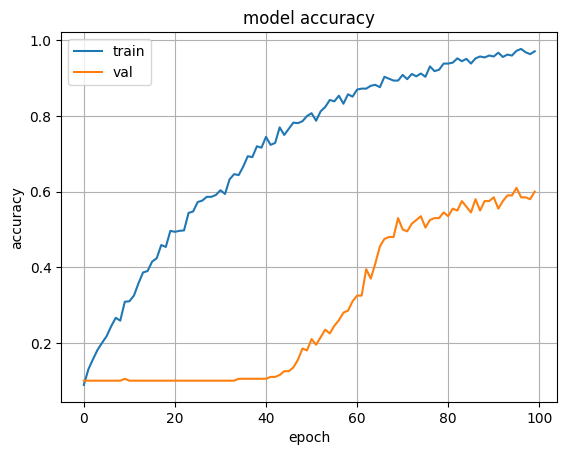

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'val'], loc='upper left')
plt.show()

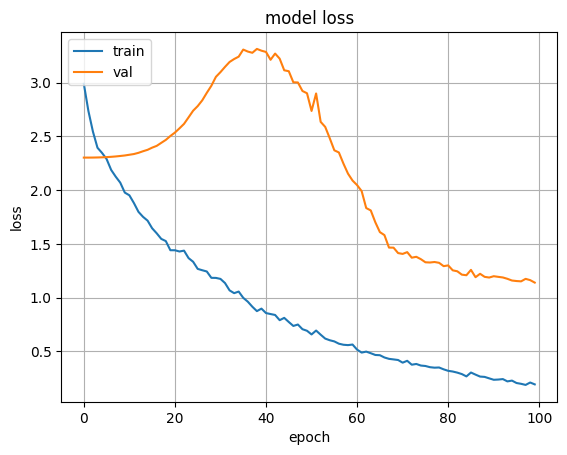

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [116]:
import pydub
from pydub import AudioSegment

pydub.AudioSegment.converter = r"C:\FFmpeg\bin\ffmpeg.exe"

def predict(image_data, model):
    image = img_to_array(image_data).reshape((1, 288, 432, 4))
    prediction = model.predict(image / 255)
    prediction = prediction.reshape((10, ))
    class_label = np.argmax(prediction)
    return class_label, prediction

def extract_relevant(file, t1, t2):
    wav = AudioSegment.from_file(file)
    wav = wav[1000*t1:1000*t2]
    wav.export("extracted.wav", format='wav')


def create_melspectrogram(wav_file):
    y, sr = librosa.load(wav_file, duration=3)
    mels = librosa.feature.melspectrogram(y=y, sr=sr)
    fig = plt.Figure()
    FigureCanvasAgg(fig)
    plt.imshow(librosa.power_to_db(mels, ref=np.max))
    plt.savefig('melspectrogram.png')
    
def classify_genre(test_file, start, end):
    extract_relevant(test_file, start, end)
    create_melspectrogram("extracted.wav")
    image_data = load_img('melspectrogram.png', color_mode='rgba', target_size=(288, 432))

    class_label, prediction = predict(image_data, model)
    prediction = prediction.reshape((10,))

    print(genre_labels[class_label])

1/1 [==============================] - 0s 17ms/step
classical
1/1 [==============================] - 0s 17ms/step
classical
1/1 [==============================] - 0s 18ms/step
classical
1/1 [==============================] - 0s 17ms/step
classical
1/1 [==============================] - 0s 18ms/step
classical
1/1 [==============================] - 0s 18ms/step
classical
1/1 [==============================] - 0s 18ms/step
classical
1/1 [==============================] - 0s 17ms/step
classical
1/1 [==============================] - 0s 17ms/step
classical
1/1 [==============================] - 0s 16ms/step
classical
1/1 [==============================] - 0s 17ms/step
classical
1/1 [==============================] - 0s 17ms/step
classical
1/1 [==============================] - 0s 17ms/step
classical
1/1 [==============================] - 0s 18ms/step
classical
1/1 [==============================] - 0s 17ms/step
classical


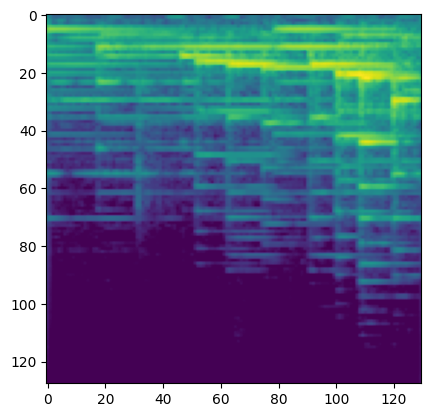

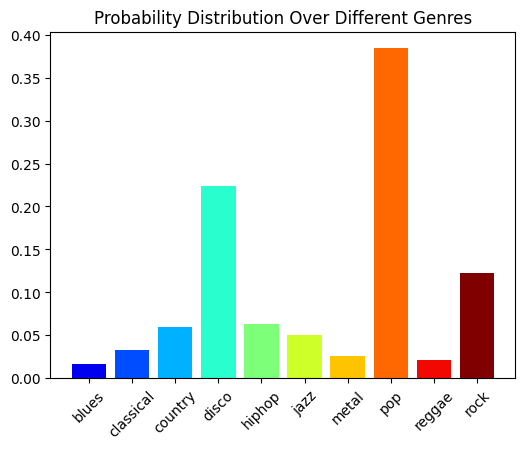

In [122]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import streamlit as st

test_file = 'nocturne.mp3'

for i in range(15):
    classify_genre(test_file, 10 * (i + 1), 10 * (i + 2))

color_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=10)

st.write(f"### Genre Prediction: {genre_labels[class_label]}")
fig, ax = plt.subplots(figsize=(6, 4.5))
ax.bar(x=genre_labels, height=prediction,
       color=my_cmap(my_norm(color_data)))
plt.xticks(rotation=45)
ax.set_title(
    "Probability Distribution Over Different Genres")
st.pyplot(fig)

st.write(f"### Mel Spectrogram")
st.image("melspectrogram.png", use_column_width=True)
plt.show()